In [8]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
# model.data 코드

# 데이터셋 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
# model.augmentat 코드

import random


# cutmix
def cutmix(image, label, prob = 1.0, batch_size = 16, img_size = 224):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([], 0, batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_img, mixed_label = mixer(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

"""
# augment
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_contrast(image, 0.2, 0.5)
    image = tf.image.random_hue(image, 0.2)
    image = tf.image.random_saturation(image, 0.2, 0.5)
    image = tf.clip_by_value(image, 0, 1)
    return image, label
"""

# augment with randomness
def augment(image, label):
    if random.choice([True, False]):
        image = tf.image.random_flip_left_right(image)
    if random.choice([True, False]):
        image = tf.image.random_flip_up_down(image)
    if random.choice([True, False]):
        brightness_factor = random.uniform(0, 0.2)
        image = tf.image.random_brightness(image, brightness_factor)
    if random.choice([True, False]):
        contrast_lower = random.uniform(0.2, 0.5)
        contrast_upper = random.uniform(contrast_lower, 0.5)
        image = tf.image.random_contrast(image, contrast_lower, contrast_upper)
    if random.choice([True, False]):
        hue_factor = random.uniform(0, 0.2)
        image = tf.image.random_hue(image, hue_factor)
    if random.choice([True, False]):
        saturation_lower = random.uniform(0.2, 0.5)
        saturation_upper = random.uniform(saturation_lower, 0.5)  # Ensure upper is always >= lower
        image = tf.image.random_saturation(image, saturation_lower, saturation_upper)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [11]:
# model.base_code 코드
# 이미지의 박스를 구하는 함수
# 이미지의 크기를 입력받아서 박스의 좌표를 반환
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

# mix two images
def mixer(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # image_a의 박스 영역을 image_b의 박스 영역으로 바꾸기
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    # label_a와 label_b를 섞어서 반환
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_img, mixed_label

# normalize and resize image [학습전 이미지 사이즈 조정]
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

# 전체 처리
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [13]:
# 트레인 데이터셋
# ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=False)
# ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=False)
# ds_train_no_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=False)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=True, with_mixup=False)
# ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=False, with_cutmix=False, with_mixup=True)

# 테스트 데이터셋
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

In [14]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

"""
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
resnet50_no_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

resnet50_aug_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
"""

In [24]:
EPOCH = 20

In [25]:
model_list = [resnet50_cutmix, resnet50_mixup]

for res_model in model_list:
    res_model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
        metrics=['accuracy'],
    )


history_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


history_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
"""
history_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_aug = resnet50_aug.fit(
    ds_train_aug,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

history_no_cutmix = resnet50_no_cutmix.fit(
    ds_train_no_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


history_aug_cutmix = resnet50_aug_cutmix.fit(
    ds_train_aug_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
"""

Epoch 1/20
750/750 [==============================] - 71s 66ms/step - loss: 1.8472 - accuracy: 0.5619 - val_loss: 2.2011 - val_accuracy: 0.4258
Epoch 2/20
750/750 [==============================] - 49s 65ms/step - loss: 1.1164 - accuracy: 0.7242 - val_loss: 2.0979 - val_accuracy: 0.4521
Epoch 3/20
750/750 [==============================] - 49s 65ms/step - loss: 0.7383 - accuracy: 0.8229 - val_loss: 1.8166 - val_accuracy: 0.5090
Epoch 4/20
750/750 [==============================] - 49s 65ms/step - loss: 0.4769 - accuracy: 0.8923 - val_loss: 1.7590 - val_accuracy: 0.5264
Epoch 5/20
750/750 [==============================] - 49s 65ms/step - loss: 0.3047 - accuracy: 0.9396 - val_loss: 1.7175 - val_accuracy: 0.5450
Epoch 6/20
750/750 [==============================] - 49s 65ms/step - loss: 0.1715 - accuracy: 0.9722 - val_loss: 1.8339 - val_accuracy: 0.5366
Epoch 7/20
750/750 [==============================] - 49s 65ms/step - loss: 0.0935 - accuracy: 0.9884 - val_loss: 1.7829 - val_accuracy:

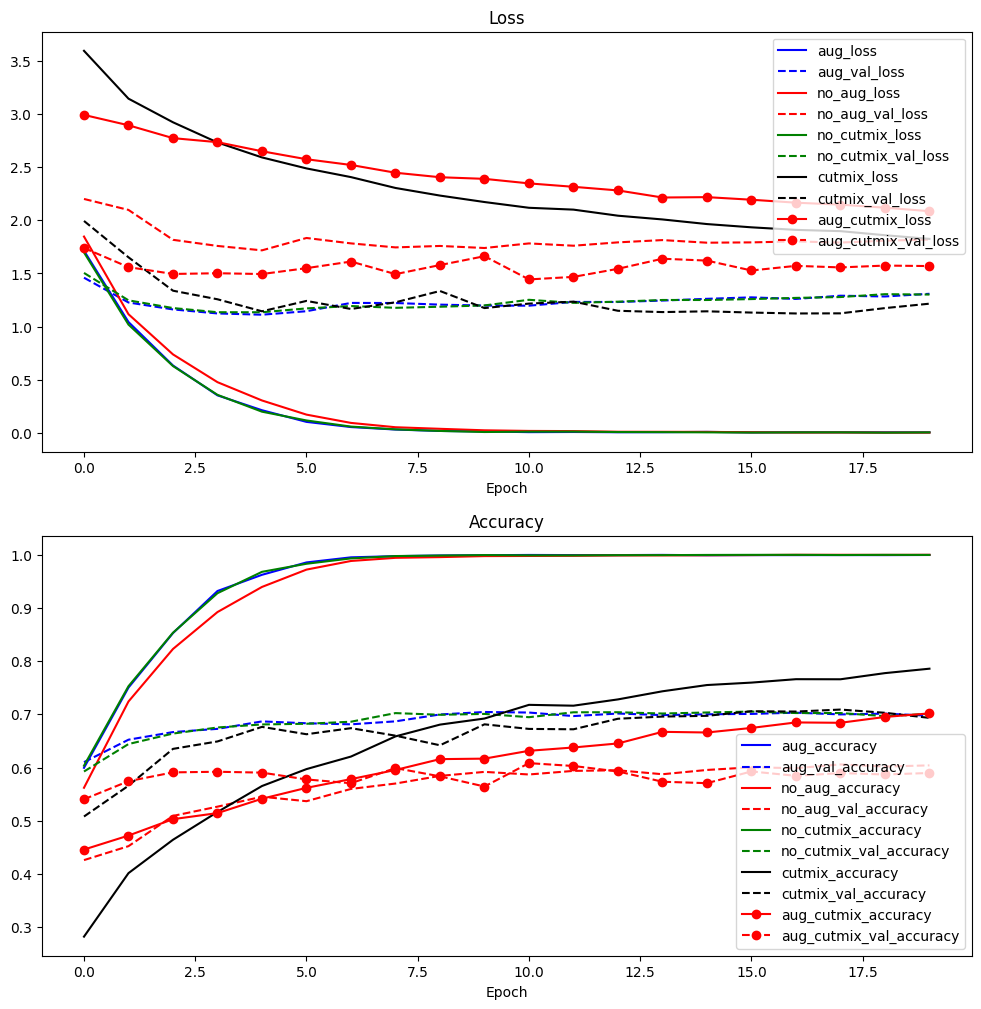

In [32]:
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_mixup.history['loss'], 'b-', label='mixup_loss')
plt.plot(history_mixup.history['val_loss'], 'b--', label='mixup_val_loss')
plt.plot(history_cutmix.history['loss'], 'r-', label='cutmix_loss')
plt.plot(history_cutmix.history['val_loss'], 'r--', label='cutmix_val_loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history_mixup.history['accuracy'], 'g-', label='mixup_accuracy')
plt.plot(history_mixup.history['val_accuracy'], 'g--', label='mixup_val_accuracy')
plt.plot(history_cutmix.history['accuracy'], 'y-', label='cutmix_accuracy')
plt.plot(history_cutmix.history['val_accuracy'], 'y--', label='cutmix_val_accuracy')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()